We begin by importing some required modules for our analysis.

In [1]:
%matplotlib inline

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import pickle   

The idea of the following explorations is to train a simple baseline model that attempts to predict congestions and traffic jams at the intersection of highway A13 and road N470, in the direction from The Hague to Rotterdam. 

Manually checking the coordinates in the data from NDW ( see Info A13 N470 1.1.csv ) and converting coordinates to Rijksdriehoeksmeting system ( http://www.gpscoordinaten.nl/converteer-rd-coordinaten.php ), we identify the columns corresponding to the intersection of interest.

In [2]:
n470_hects = range(53,70)

For our features, we will use speed and flow data from a neighborhood of 20 hectometers before and after the intersection

In [5]:
ngbr_hects = range(33,90)

rf = pd.read_csv('a13/Rechts_Flow_2011.csv', header=None)
rs = pd.read_csv('a13/Rechts_Speed_2011.csv', header=None)
df = pd.concat([rf.iloc[:,ngbr_hects], rs.iloc[:,ngbr_hects]],axis=1)

We begin with a naive definition of what we consider to be a congestion.
We just compute, for each moment, the average speed over the intersection. The moments where this speed is below a reasonable threshold will be considered congestions. Let us plot these average speeds to get a better intuition.

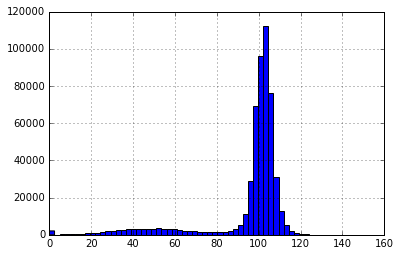

In [6]:
rs_intersection = rs.iloc[:,n470_hects]

inters_means = rs_intersection.mean(axis=1)

inters_means.hist(bins=60)

We see in the histogram that speeds of 95 or less are rare, so we take that as our threshold for congestion

In [7]:
jam_threshold = 95

Armed with this information we can already make our first experiment in training a predictive model.
We will start with one that tries to predict congestions with 5 minutes of anticipation, using the flow and speed dataset created above.

In [8]:
mins_diff=5
y = (inters_means < jam_threshold)[mins_diff:]
df = df.iloc[:-mins_diff,:]

Seasonality can have a big impact on the behaviour of traffic, and on the other hand, over 500k rows of data is a lot to train on, so we propose creating separate models and datasets for separate quarters of the year.

In [41]:
quarter_size = df.shape[0]//4

df1 = df.iloc[:quarter_size,:]
y1 = y[:quarter_size]

df2 = df.iloc[quarter_size:2*quarter_size,:]
y2 = y[quarter_size:2*quarter_size]

df3 = df.iloc[2*quarter_size:3*quarter_size,:]
y3 = y[2*quarter_size:3*quarter_size]

df4 = df.iloc[3*quarter_size:,:]
y4 = y[3*quarter_size:]

Let us now start with a dataset for 1st quarter

In [42]:
df, y = df1, y1

We choose to do the train/test split based on temporality and not at random, to make the evaluation of the model more realistic, and also to avoid contamination of train data with measurements lying too close to those in test data.

In [44]:
def train_test_split(df, y, test_size=0.3):
    cut = int(len(y) * test_size)

    X_train = df.iloc[:-cut,:]
    X_test = df.iloc[-cut:,:]

    y_train = y[:-cut]
    y_test = y[-cut:]

    return X_train, X_test, y_train, y_test

In [45]:
X_train, X_test, y_train, y_test =  train_test_split(df, y)

Now we try to fit an out-of-the-box RandomForestClassifier to the train set and see how it performs

In [46]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.98      0.99      0.98     33537
       True       0.93      0.86      0.89      5882

avg / total       0.97      0.97      0.97     39419



Not bad! But may be we can do better, specially when it comes to recall, which actually tells us how many of these congestion moments we are able to predict.

This classification problem is very unbalanced, as the congestion state is much less frequent than the smooth state (fortunately!).

We can pass a class_weight parameter to our RandomForest to make it more aware of this situation.

In [48]:
clf = RandomForestClassifier(class_weight='balanced')
y_pred = clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.97      0.99      0.98     33537
       True       0.94      0.82      0.88      5882

avg / total       0.97      0.97      0.97     39419



It improved in precision, but recall went down. Let's a different balancing method

In [49]:
clf = RandomForestClassifier(class_weight='balanced_subsample')
y_pred = clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.97      0.99      0.98     33537
       True       0.94      0.82      0.88      5882

avg / total       0.97      0.97      0.97     39419



Ok, let us leave the weights out for now, they don't seem to be helping.

In [50]:
clf = RandomForestClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.98      0.99      0.98     33537
       True       0.93      0.86      0.89      5882

avg / total       0.97      0.97      0.97     39419



Now let's see what happens for the other quarters

### Q2

In [56]:
X_train, X_test, y_train, y_test =  train_test_split(df2, y2)
clf = RandomForestClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.97      0.99      0.98     31370
       True       0.94      0.87      0.90      8049

avg / total       0.96      0.96      0.96     39419



Mmmm... not really. We'll investigate this one later. Let's move on for now

### Q3

In [57]:
X_train, X_test, y_train, y_test =  train_test_split(df3, y3)
clf = RandomForestClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.97      0.99      0.98     32690
       True       0.94      0.83      0.88      6729

avg / total       0.96      0.96      0.96     39419



### Q4

In [58]:
X_train, X_test, y_train, y_test =  train_test_split(df4, y4)
clf = RandomForestClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.96      0.99      0.98     32777
       True       0.95      0.81      0.88      6643

avg / total       0.96      0.96      0.96     39420



From this data we can also quickly see which is the quarter with more congestion time:


In [61]:
[sum(y)/60 for y in [y1, y2, y3, y4]]

[384.75, 424.41666666666669, 264.46666666666664, 425.60000000000002]

It's almost a tie between Q2 and Q4 with around 425 hours of congestion time each.

## More anticipation

We now try with longer intervals of anticipation, to see how this affects the quality of the model.
Let us do it for Q2 to begin with. First we define some auxiliary functions

In [62]:
def get_datasets_q2(mins_diff=10):
    y = (inters_means < jam_threshold)[mins_diff:]

    df = pd.concat([rf.iloc[:,ngbr_hects], rs.iloc[:,ngbr_hects]],axis=1)
    df = df.iloc[:-mins_diff,:]

    df2 = df.iloc[quarter_size:2*quarter_size,:]
    y2 = y[quarter_size:2*quarter_size]
    
    return df2, y2

def train_eval(df, y):
    X_train, X_test, y_train, y_test =  train_test_split(df, y)
    clf = RandomForestClassifier()
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, y_pred))

Ok, now let us experiment with different levels of anticipation and see how this affects the quality of the predictons.

In [65]:
for mins in [10, 20, 30, 40, 50, 60]:
    print ("Trying to predict with %d mins of anticipation" % mins)
    df, y = get_datasets_q2(mins)
    train_eval(df, y)

Trying to predict with 10 mins of anticipation
             precision    recall  f1-score   support

      False       0.96      0.98      0.97     31372
       True       0.92      0.83      0.87      8047

avg / total       0.95      0.95      0.95     39419

Trying to predict with 20 mins of anticipation
             precision    recall  f1-score   support

      False       0.94      0.97      0.96     31372
       True       0.87      0.77      0.82      8047

avg / total       0.93      0.93      0.93     39419

Trying to predict with 30 mins of anticipation
             precision    recall  f1-score   support

      False       0.93      0.96      0.95     31372
       True       0.83      0.70      0.76      8047

avg / total       0.91      0.91      0.91     39419

Trying to predict with 40 mins of anticipation
             precision    recall  f1-score   support

      False       0.91      0.96      0.93     31372
       True       0.80      0.64      0.71      8047

avg / 